In this Article We will try solving language translation problem by training a transformer model from the scratch. While working on this we we closely refer to:
* https://github.com/soutrik71/pytorch-transformer/blob/main/model.py
* https://github.com/soutrik71/pytorch-transformer/blob/main/model.py
* https://medium.com/@luuisotorres/building-and-training-a-transformer-from-scratch-fdbf3db00df4
* https://medium.com/@bagusmurdyantoro1997/building-transformer-from-scratch-in-pytorch-fd78de4c1bbc

In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os
os.chdir("/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/EraV2_Transformers")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/EraV2_Transformers


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import torch.functional as F
import math

## MODEL BUILDING

In [4]:
seq_len = 16
vocab_size = 100
d_model = 512

In [5]:
input_batch = torch.randint(0, vocab_size, (1, seq_len))
print(input_batch.shape)

torch.Size([1, 16])


### Input Layer for Both Encoder and Decoder

#### Embedding Model -- Convert the input to embeddings for a given input size

In [6]:
class InputEmbeddings(nn.Module):
    """
    This class is responsible for creating the input embeddings for the model
    """

    def __init__(self, d_model: int, vocab_size: int):
        super(InputEmbeddings, self).__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(self.vocab_size, self.d_model)

    def forward(self, x):
        # (batch_size, seq_len) -> (batch_size, seq_len, d_model)
        op = self.embedding(x) * math.sqrt(self.d_model)
        return op

In [7]:
input_embeddings = InputEmbeddings(d_model, vocab_size)
embedding_op = input_embeddings(input_batch)
print(embedding_op.shape)

torch.Size([1, 16, 512])


#### Positional Encoding-- Add the positional embeddings to the input embeddings for capturing the position of the words in the sentence

In [8]:
class PositionalEncoding(nn.Module):
    """This class is responsible for creating the positional encoding for the model"""

    def __init__(self, d_model: int, seq_len: int, dropout_rate: float):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(
            dropout_rate
        )  # added post we add embeddings to the positional encoding

        pe = self._postional_encoding_matrix()

        self.register_buffer("pe", pe)

    def _postional_encoding_matrix(self):
        # we will multiply a position matrix pos with dimension (seq_len,1) with an encoding matrix with dimension (1, d_model) to get a matrix with dimension (seq_len, d_model)
        position = torch.arange(0, self.seq_len).unsqueeze(1)  # (seq_len, 1)

        # to create the embedding matrix we will use d_model/2 as the dimension of the sin and cos functions
        embedding = torch.arange(0, self.d_model, 2).float()  # (d_model/2)

        # next we will create the devision factor for the positional encoding
        div_term = torch.exp(embedding * -(math.log(10000.0) / self.d_model))

        # create a postional encoding matrix of dimension (seq_len, d_model)
        pe = torch.zeros(self.seq_len, self.d_model)

        # apply sin to even indices and cos to odd indices of the position matrix

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # in order to add the positional encoding to the input embeddings we need to add a batch dimension to the positional encoding matrix
        pe = pe.unsqueeze(0)  # (1, seq_len, d_model)
        return pe

    def forward(self, x):
        op = x + (self.pe[:, : x.shape[1], :]).requires_grad_(False)
        return self.dropout(op)

In [9]:
pos_encoding = PositionalEncoding(d_model, seq_len, 0.1)
pos_encoding_op = pos_encoding(embedding_op)
print(pos_encoding_op.shape)

torch.Size([1, 16, 512])


### [Masked]MultiHeadAttention -- Split the input into multiple heads and apply attention mechanism

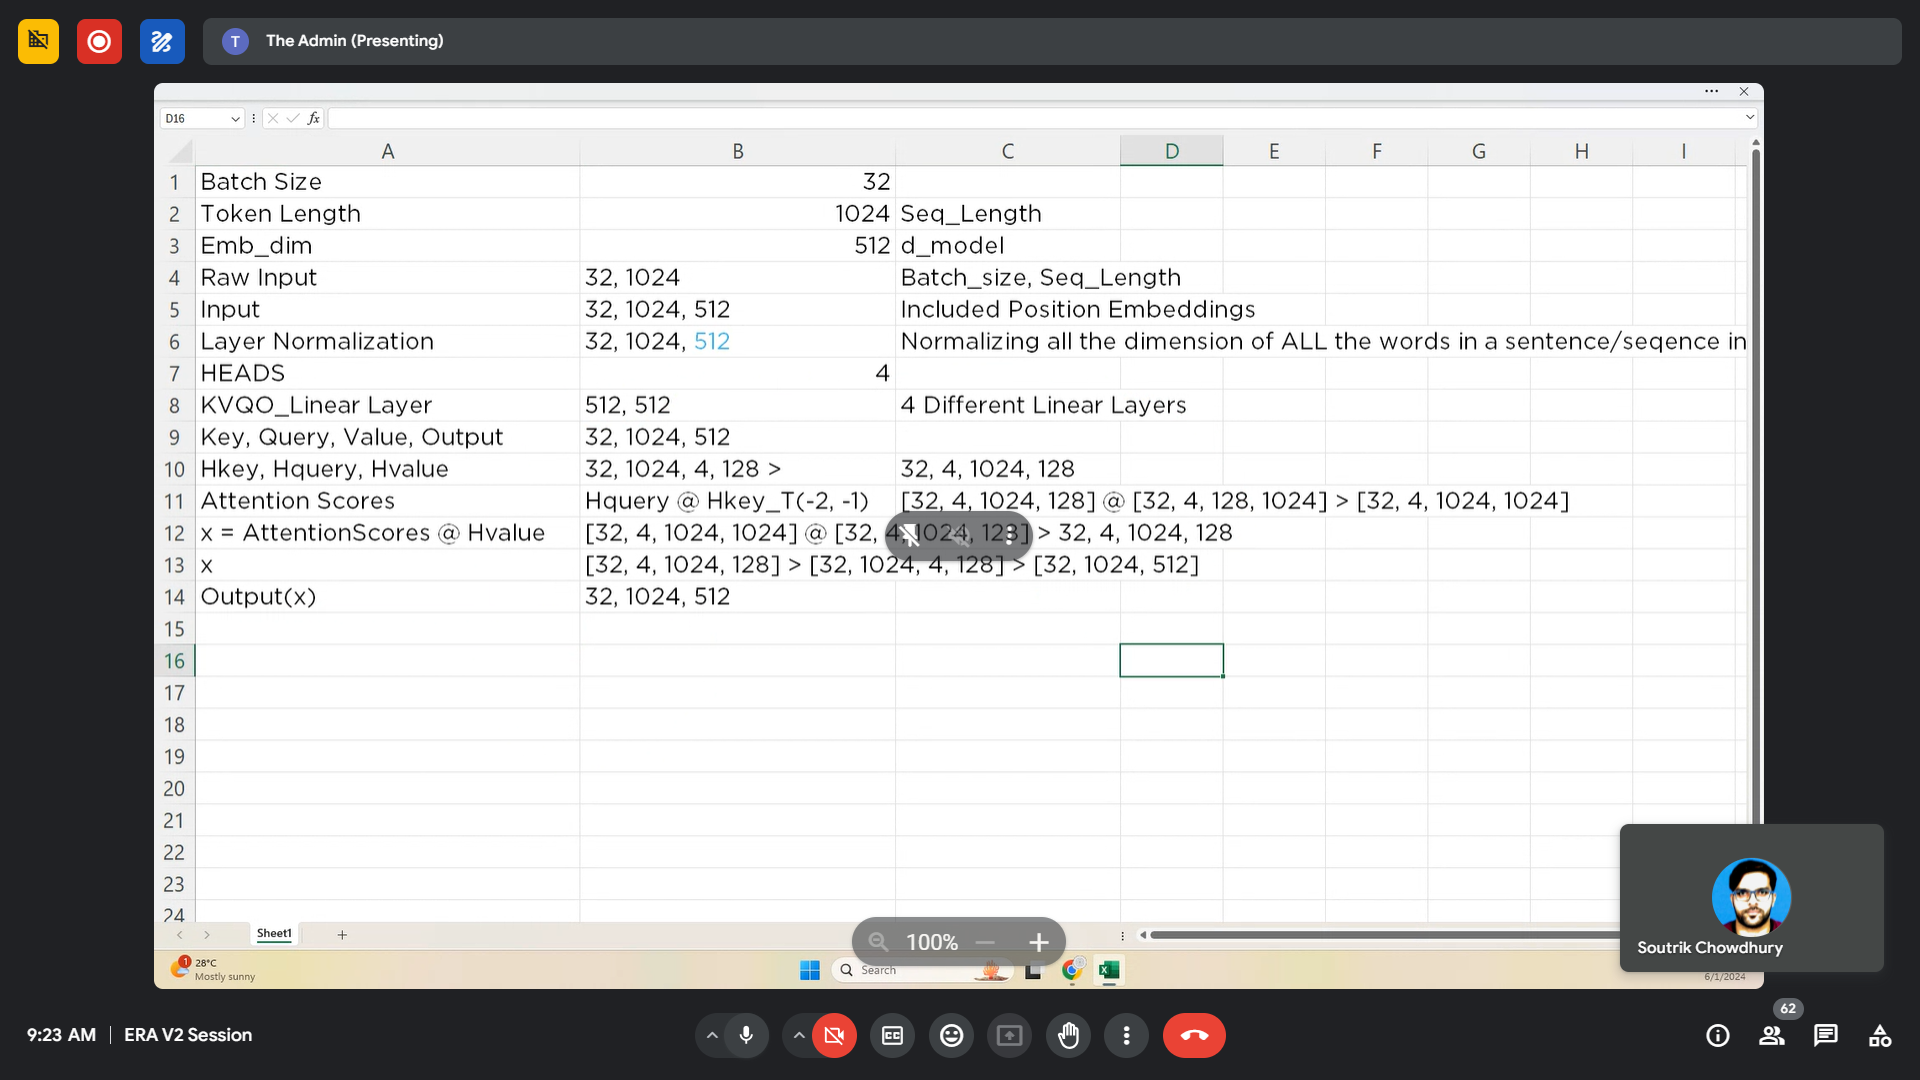

In [10]:
q = torch.randn(1, seq_len, d_model)
k = torch.randn(1, seq_len, d_model)
v = torch.randn(1, seq_len, d_model)

In [11]:
class MultiHeadAttentionBlock(nn.Module):
    """This class is responsible for creating the multi head attention block"""

    def __init__(self, d_model: int, h: int, dropout_rate: float):
        super(MultiHeadAttentionBlock, self).__init__()
        self.d_model = d_model
        self.h = h
        self.dropout = nn.Dropout(dropout_rate)

        assert d_model % h == 0, "d_model must be divisible by h"
        self.d_k = (
            d_model // h
        )  # dimension for query, key and value matrix under each head

        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)

    @staticmethod
    def attention_block(query, key, value, mask, dropout):
        d_k = query.shape[-1]
        # each matrix after head split is of size (batch, h, seq_len, d_k), so (batch, h, seq_len, d_k) @ (batch, h, d_k, seq_len) = (batch, h, seq_len, seq_len)
        qk = query @ key.transpose(-2, -1)
        scaled_qk = qk / math.sqrt(d_k)

        if mask is not None:
            # where mask is 0, we will replace the value with -1e9
            scaled_qk = scaled_qk.masked_fill(mask == 0, -1e9)

        attention = torch.softmax(scaled_qk, dim=-1)

        if dropout is not None:
            attention = dropout(attention)

        # the output should be same as input value matrix, so (batch, h, seq_len, seq_len) @ (batch, h, seq_len, d_k) = (batch, h, seq_len, d_k)

        scores = attention @ value

        return scores, attention

    def forward(self, q, k, v, mask):
        # initally q,k,v are in the shape of (batch, seq_len, d_model) , we need to convert them into the shape of (batch, h, seq_len, d_k)
        # before that we have to add weights to q,k,v using the linear layers
        query = self.wq(q)
        key = self.wk(k)
        value = self.wv(v)

        # the conversion is (batch,seq_len,d_model) -> (batch, seq_len , h, d_k) -> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(
            1, 2
        )
        key = key.view(key.shape[0], key.shape[1],
                       self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(
            1, 2
        )

        # print(query.shape)
        # print(key.shape)
        # print(value.shape)

        # next we calculate attention score
        x, self.attention_scores = MultiHeadAttentionBlock.attention_block(
            query, key, value, mask, self.dropout
        )

        # x is in the shape of (batch, h, seq_len, d_k) -> (batch, seq_len, h, d_k) -> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(
            x.shape[0], -1, self.h * self.d_k)

        op = self.wo(x)
        return op

In [12]:
attention = MultiHeadAttentionBlock(d_model, 8, 0.1)
op = attention(q, k, v, None)
print(op.shape)

torch.Size([1, 16, 512])


### Add and Norm Layer -- Layer Normalization and Residual Connection

In [13]:
class LayerNormalization(nn.Module):
    """This class is responsible for creating the layer normalization block"""

    def __init__(self, features: int, eps: float = 1e-6):
        super(LayerNormalization, self).__init__()
        self.features = features
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(self.features))
        self.beta = nn.Parameter(torch.zeros(self.features))

    def forward(self, x):
        # x is of shape (batch, seq_len, hidden_dim)
        mean = x.mead(dim=-1, keepdim=True)  # (batch, seq_len, 1)
        std = x.std(dim=-1, keepdim=True)  # (batch, seq_len, 1)

        norm_op = self.alpha * (x - mean) / (std + self.eps) + self.beta
        return norm_op

In [14]:
class ResidualConnection(nn.Module):
    """This class is responsible for creating the residual connection block ie Pre-Layer Normalization block"""

    def __init__(self, features: int, dropout_rate: float):
        super(ResidualConnection, self).__init__()
        self.features = features
        self.dropout = nn.Dropout(self.dropout_rate)
        self.norm = LayerNormalization(self.features)

    def forward(self, x, sublayer):
        residual_op = x + self.dropout(sublayer(self.norm(x)))
        return residual_op

### Feed Forward Network - Addition of output of MultiHeadAttentionBlock and ResidualConnection Block to a feed forward network
* this is where you can use gelu and tryout other activation functions

In [15]:
class FeedForwardBlock(nn.Module):
    """This class is responsible for creating the feed forward block"""

    def __init__(self, d_model: int, d_ff: int, dropout_rate: float):
        super(FeedForwardBlock, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout = nn.Dropout(dropout_rate)

        self.linear1 = nn.Linear(self.d_model, self.d_ff)
        self.linear2 = nn.Linear(self.d_ff, self.d_model)

    def forward(self, x):
        # (batch,seq_len,d_model) -> (batch,seq_len,d_ff) -> (batch,seq_len,d_model)
        linear1_op = self.linear1(x)
        linear1_op = torch.relu(linear1_op)
        linear1_op = self.dropout(linear1_op)
        linear2_op = self.linear2(linear1_op)

        return linear2_op

### Encoder Block and Encoder Sequence Cascade
* An encoder block has 2 constructs - Input from (Embedding + Positional Encoding) -> (MultiHeadAttention + Add and Norm) -> (Feed Forward + Add and Norm)
* This Block is re[eated for the `N` number of encoder layers]

In [16]:
class EncoderBlock(nn.Module):
    """This class is responsible for creating the encoder block"""

    def __init__(
        self,
        features: int,
        self_attention_block: MultiHeadAttentionBlock,
        feed_forward_block: FeedForwardBlock,
        dropout_rate: float,
    ):
        super(EncoderBlock, self).__init__()
        self.features = features
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList(
            [ResidualConnection(self.features, dropout_rate) for _ in range(2)]
        )  # 2 residual connections in the encoder block

    def forward(self, x, src_mask):
        x = self.residual_connections[0](
            x, lambda x: self.self_attention_block(x, x, x, src_mask)
        )
        x = self.residual_connections[1](x, self.feed_forward_block)

        return x

In [17]:
class Encoder(nn.Module):
    """This class is responsible for creating the encoder sequence of the transformer model"""

    def __init__(self, features: int, layers: nn.ModuleList):
        super(Encoder, self).__init__()
        self.load_state_dict
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)